<a href="https://colab.research.google.com/github/yiwenwangANU/Machine_Learning/blob/main/04_Transfer_Learning_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip", 'r')
zip_ref.extractall()
zip_ref.close()

--2022-05-27 01:04:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   227MB/s    in 6.1s    

2022-05-27 01:04:07 (253 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [ ]:
import os

for path, dirname, filename in os.walk("101_food_classes_10_percent"):
  print(f"Current directory: {path}, number of sub-dirs: {len(dirname)}, \
  number of files: {len(filename)}")

In [ ]:
train_data_10_percent_dir = "101_food_classes_10_percent/train"
test_data_10_percent_dir = "101_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

In [ ]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_10_percent_dir,
    label_mode='categorical',
    image_size=(224, 224)
)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_10_percent_dir,
    label_mode='categorical',
    image_size=(224, 224)
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
import datetime
def create_tensorboard_callback(path, filename):
  log_dir = os.path.join(path, filename, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  callback = tf.keras.callbacks.TensorBoard(log_dir)
  return callback

In [ ]:
def create_modelcheckpoint_callback(path, filename):
  filepath = os.path.join(path, filename)
  callback = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, 
                                                save_weights_only=True)
  return callback

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

augment_layers = tf.keras.Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2)
])

In [ ]:
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
x = augment_layers(input_layer)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer = tf.keras.layers.Dense(len(train_data_10_percent.class_names), 
                                     activation='softmax')(x)
model_0 = tf.keras.Model(input_layer, output_layer)

In [ ]:
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history_10_percent_FE = model_0.fit(train_data_10_percent,
                                    epochs=initial_epochs,
                                    validation_data=test_data_10_percent,
                                    validation_steps=int(0.15*len(test_data_10_percent)),
                                    batch_size=32,
                                    callbacks=[create_tensorboard_callback("Transfer_Learning",
                                                                           "10_percent_feature_extraction"),
                                               create_modelcheckpoint_callback("Model_Checkpoint",
                                                                               "10_percent_feature_extraction")])

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.4857 - accuracy: 0.2448
Epoch 1: saving model to Model_Checkpoint/10_percent_feature_extraction
237/237 [==============================] - 90s 308ms/step - loss: 3.4857 - accuracy: 0.2448 - val_loss: 2.4742 - val_accuracy: 0.4338
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.3731 - accuracy: 0.4550
Epoch 2: saving model to Model_Checkpoint/10_percent_feature_extraction
237/237 [==============================] - 63s 265ms/step - loss: 2.3731 - accuracy: 0.4550 - val_loss: 2.0391 - val_accuracy: 0.4984
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 2.0163 - accuracy: 0.5178
Epoch 3: saving model to Model_Checkpoint/10_percent_feature_extraction
237/237 [==============================] - 55s 231ms/step - loss: 2.0163 - accuracy: 0.5178 - val_loss: 1.8699 - val_accuracy: 0.5257
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.7895 - accuracy: 0.5708
Ep

In [ ]:
result_10_percent_FE = model_0.evaluate(test_data_10_percent)
result_10_percent_FE

790/790 [==============================] - 59s 74ms/step - loss: 1.7369 - accuracy: 0.5444


[1.7368522882461548, 0.5443564653396606]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_loss_curve(history):
    """
    plot the loss curve and accuracy curve during the model training

    :param history: a history file that records loss, val_loss, accuracy and val_accuracy during the model training
    :return: None
    """
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(history.history) + 1), history.history["loss"], label="loss")
    plt.plot(np.arange(len(history.history) + 1), history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(history.history) + 1), history.history["accuracy"], label="accuracy")
    plt.plot(np.arange(len(history.history) + 1), history.history["val_accuracy"], label="val_accuracy")
    plt.legend()

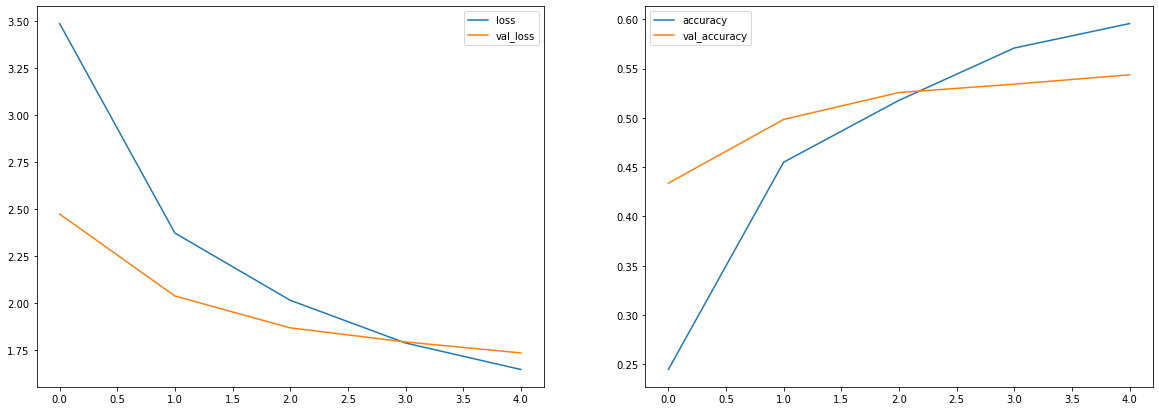

In [ ]:
plot_loss_curve(history_10_percent_FE)

In [ ]:
for layer in base_model.layers[-10:]:
  layer.trainable = True

for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

In [ ]:
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(lr=10e-4),
                metrics=(['accuracy']))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_10_percent_FT = model_0.fit(train_data_10_percent,
                                    epochs=initial_epochs+ 5,
                                    initial_epoch=history_10_percent_FE.epoch[-1],
                                    validation_data=test_data_10_percent,
                                    validation_steps=int(0.15*len(test_data_10_percent)),
                                    batch_size=32,
                                    callbacks=[create_tensorboard_callback("Transfer_Learning",
                                                                           "10_percent_fine_tune"),
                                               create_modelcheckpoint_callback("Model_Checkpoint",
                                                                               "10_percent_fine_tune")])

Epoch 5/10
237/237 [==============================] - ETA: 0s - loss: 1.5152 - accuracy: 0.6197
Epoch 5: saving model to Model_Checkpoint/10_percent_fine_tune
237/237 [==============================] - 45s 185ms/step - loss: 1.5152 - accuracy: 0.6197 - val_loss: 1.7109 - val_accuracy: 0.5508
Epoch 6/10
237/237 [==============================] - ETA: 0s - loss: 1.4053 - accuracy: 0.6570
Epoch 6: saving model to Model_Checkpoint/10_percent_fine_tune
237/237 [==============================] - 43s 179ms/step - loss: 1.4053 - accuracy: 0.6570 - val_loss: 1.6770 - val_accuracy: 0.5516
Epoch 7/10
237/237 [==============================] - ETA: 0s - loss: 1.3069 - accuracy: 0.6767
Epoch 7: saving model to Model_Checkpoint/10_percent_fine_tune
237/237 [==============================] - 42s 175ms/step - loss: 1.3069 - accuracy: 0.6767 - val_loss: 1.6762 - val_accuracy: 0.5580
Epoch 8/10
237/237 [==============================] - ETA: 0s - loss: 1.2344 - accuracy: 0.6970
Epoch 8: saving model to 

In [ ]:
result_10_percent_FT = model_0.evaluate(test_data_10_percent)

790/790 [==============================] - 57s 71ms/step - loss: 1.6372 - accuracy: 0.5625


In [ ]:
def plot_fine_turn_loss(original_history, new_history, initial_epochs): 
  loss = original_history.history["loss"] + new_history.history["loss"]
  val_loss = original_history.history["val_loss"] + new_history.history["val_loss"]
  accuracy = original_history.history["accuracy"] + new_history.history["accuracy"]
  val_accuracy = original_history.history["val_accuracy"] + new_history.history["val_accuracy"]
  plt.figure(figsize=(10, 7))
  plt.subplot(2, 1, 1)
  plt.plot(loss, label="loss")
  plt.plot(val_loss, label="val_loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tune")
  plt.legend()
  plt.subplot(2, 1, 2)
  plt.plot(accuracy, label="accuracy")
  plt.plot(val_accuracy, label="val_accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tune")
  plt.legend()

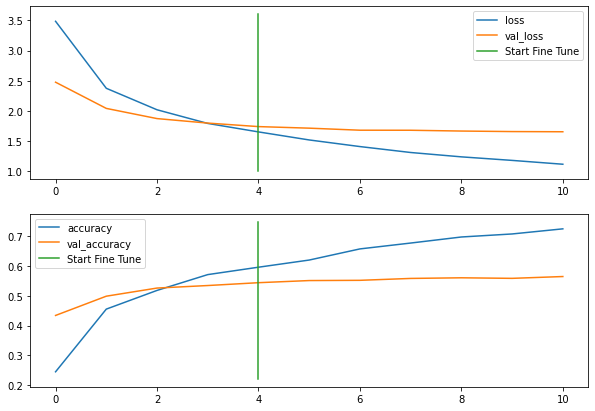

In [ ]:
plot_fine_turn_loss(history_10_percent_FE, history_10_percent_FT, 5)

In [ ]:
model_0.save("content/101_food_class_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: content/101_food_class_10_percent_saved_big_dog_model/assets


In [ ]:
model_0.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/assets


In [ ]:
model_1 = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

In [ ]:
model_1.evaluate(test_data_10_percent)

790/790 [==============================] - 61s 74ms/step - loss: 1.6372 - accuracy: 0.5625


[1.637180209159851, 0.5624554753303528]